In [1]:
#!pip3 install opencv-python
#!pip3 install scikit-image

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, exposure
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

2023-07-17 22:57:14.593700: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 22:57:14.633644: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]
df.head()

df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [3]:
df['suit'] = df['labels'].str.split().str[-1]
print(df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [4]:
# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]
card_suits = df['suit'].unique()
print(card_suits)

['clubs' 'diamonds' 'hearts' 'spades']


In [5]:
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['suit'])
df = df.drop(columns = ['card_type'])
df.head()

,filepaths,labels
0,train/ace of clubs/001.jpg,ace of clubs
1,train/ace of clubs/002.jpg,ace of clubs
2,train/ace of clubs/003.jpg,ace of clubs
3,train/ace of clubs/004.jpg,ace of clubs
4,train/ace of clubs/005.jpg,ace of clubs


In [6]:
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,labels
0,Dataset/train/ace of clubs/001.jpg,ace of clubs
1,Dataset/train/ace of clubs/002.jpg,ace of clubs
2,Dataset/train/ace of clubs/003.jpg,ace of clubs
3,Dataset/train/ace of clubs/004.jpg,ace of clubs
4,Dataset/train/ace of clubs/005.jpg,ace of clubs


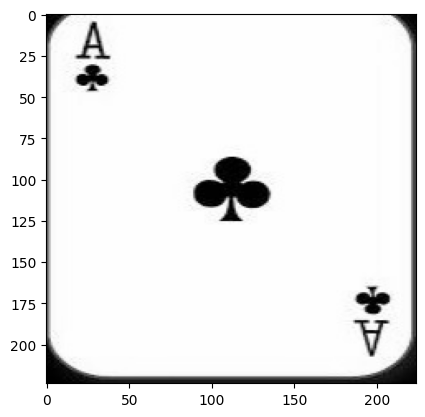

In [7]:
test = cv2.imread('DatasetPreProcessed/train/ace of clubs/112.jpg')
plt.imshow(test)
plt.show()

In [8]:
class_counts = df['labels'].value_counts()
class_counts


ace of spades        191
jack of spades       182
jack of clubs        181
ace of hearts        181
jack of hearts       178
seven of spades      175
queen of diamonds    173
queen of spades      172
queen of clubs       171
jack of diamonds     170
eight of diamonds    169
six of spades        168
ten of spades        168
five of spades       168
four of clubs        167
two of spades        165
two of hearts        165
nine of spades       164
four of hearts       164
three of diamonds    163
six of clubs         162
eight of hearts      162
king of spades       161
ten of diamonds      161
five of clubs        160
seven of hearts      153
three of spades      152
ten of clubs         151
four of spades       150
queen of hearts      149
six of diamonds      149
five of diamonds     148
eight of clubs       148
five of hearts       146
king of diamonds     145
eight of spades      145
two of diamonds      143
nine of hearts       143
two of clubs         140
ace of diamonds      139


In [9]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [10]:
# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['labels'].value_counts(normalize=True)
val_class_distribution = val_df['labels'].value_counts(normalize=True)
test_class_distribution = test_df['labels'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
ace of spades        0.023745
jack of spades       0.022772
ace of hearts        0.022577
jack of clubs        0.022577
jack of hearts       0.021993
seven of spades      0.021798
queen of spades      0.021409
queen of diamonds    0.021409
queen of clubs       0.021409
jack of diamonds     0.021214
eight of diamonds    0.021020
six of spades        0.020825
four of clubs        0.020825
ten of spades        0.020825
five of spades       0.020825
two of hearts        0.020631
two of spades        0.020631
nine of spades       0.020436
four of hearts       0.020436
three of diamonds    0.020241
eight of hearts      0.020241
six of clubs         0.020241
king of spades       0.020047
ten of diamonds      0.020047
five of clubs        0.019852
seven of hearts      0.019074
three of spades      0.019074
ten of clubs         0.018879
four of spades       0.018684
queen of hearts      0.018490
six of diamonds      0.018490
eight of clubs       0.018295
five of 

## Augment Images

In [11]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

In [12]:
# Create data generators for train, validation, and test

batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 52 classes.
Found 1285 validated image filenames belonging to 52 classes.
Found 1606 validated image filenames belonging to 52 classes.


## ResNet

In [13]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

print(base_model.summary())

2023-07-17 22:57:16.434738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-17 22:57:16.456033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-17 22:57:16.456091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-17 22:57:16.574082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-17 22:57:16.574128: I tensorflow/compile

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
flatten_layer = tf.keras.layers.Flatten()(base_model.output)
last_hidden_output = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
last_hidden_output = tf.keras.layers.Dropout(0.03)(last_hidden_output)
last_hidden_output = tf.keras.layers.Dense(256, activation='relu')(last_hidden_output)
last_hidden_output = tf.keras.layers.Dropout(0.03)(last_hidden_output)
last_hidden_output = tf.keras.layers.Dense(128, activation='relu')(last_hidden_output)
last_hidden_output = tf.keras.layers.Dropout(0.03)(last_hidden_output)

prediction  = Dense(52, activation='softmax')(last_hidden_output)
model = Model(inputs=base_model.input, outputs=prediction)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
learning_rate = 0.00001

model.compile(
    optimizer=Adam(learning_rate=learning_rate),#tf.keras.optimizers.Adam(learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
epochs = 50
 
result = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=len(valid_generator)
            )

Epoch 1/50


2023-07-17 22:57:23.024092: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-17 22:57:26.186106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-17 22:57:27.170657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/161 [==============================] - ETA: 0s - loss: 3.8250 - accuracy: 0.0629

2023-07-17 22:57:56.405464: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


161/161 [==============================] - 41s 220ms/step - loss: 3.8250 - accuracy: 0.0629 - val_loss: 4.0759 - val_accuracy: 0.0148
Epoch 2/50
161/161 [==============================] - 32s 198ms/step - loss: 3.1471 - accuracy: 0.1543 - val_loss: 4.1765 - val_accuracy: 0.0280
Epoch 3/50
161/161 [==============================] - 33s 204ms/step - loss: 2.6313 - accuracy: 0.2631 - val_loss: 3.7555 - val_accuracy: 0.0802
Epoch 4/50
161/161 [==============================] - 32s 197ms/step - loss: 2.3666 - accuracy: 0.3260 - val_loss: 2.9794 - val_accuracy: 0.2296
Epoch 5/50
161/161 [==============================] - 32s 197ms/step - loss: 2.1069 - accuracy: 0.3953 - val_loss: 2.5128 - val_accuracy: 0.3198
Epoch 6/50
161/161 [==============================] - 33s 206ms/step - loss: 1.9399 - accuracy: 0.4438 - val_loss: 2.1508 - val_accuracy: 0.4039
Epoch 7/50
161/161 [==============================] - 32s 198ms/step - loss: 1.7862 - accuracy: 0.4790 - val_loss: 1.9259 - val_accuracy: 0.4

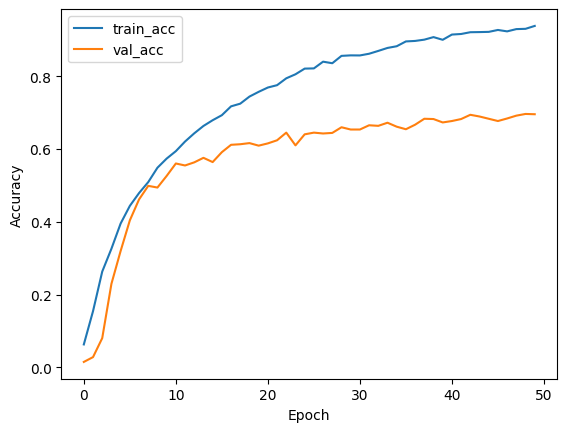

In [17]:
#Plot accuracy
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

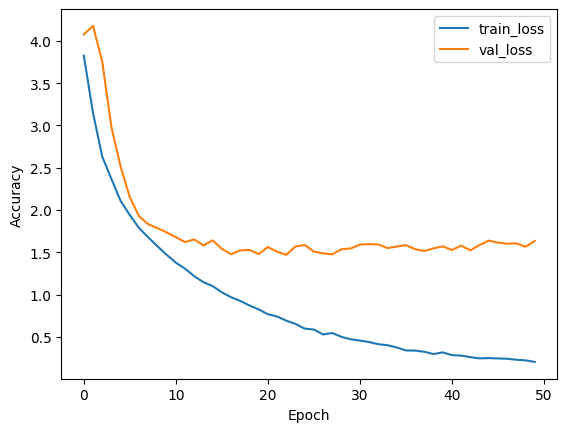

In [18]:
#Plot Loss
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Evaluate the model on the test set
evaluation = model.evaluate(valid_generator, steps=len(valid_generator))

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

2023-07-17 23:24:16.834398: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 6s 154ms/step - loss: 1.5480 - accuracy: 0.6911
Loss: 1.5479856729507446
Accuracy: 0.6910505890846252


In [20]:
predictions=model.predict_generator(test_generator)

predicted_labels = predictions.argmax(axis=-1)
print(predicted_labels)

/tmp/ipykernel_110410/971083817.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(test_generator)
2023-07-17 23:24:23.278176: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[ 5 10 17 ... 40 17 37]


In [21]:
# Get the true labels from the test generator
true_labels = test_generator.classes

# Convert the predicted labels to numpy array
predicted_labels = predictions.argmax(axis=-1)

# Compute precision, recall, and F1 score
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        26
           1       0.79      0.79      0.79        28
           2       0.79      0.72      0.75        36
           3       0.87      0.87      0.87        38
           4       0.70      0.70      0.70        30
           5       0.73      0.79      0.76        34
           6       0.83      0.75      0.79        32
           7       0.57      0.83      0.68        29
           8       0.80      0.62      0.70        32
           9       0.76      0.83      0.79        30
          10       0.81      0.76      0.79        29
          11       0.74      0.76      0.75        34
          12       0.82      0.70      0.75        33
          13       0.83      0.76      0.79        25
          14       0.74      0.70      0.72        33
          15       0.84      0.70      0.76        30
          16       0.62      0.81      0.70        36
          17       0.65    

In [22]:
# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7581180941859544
Recall: 0.7465753424657534
F1 Score: 0.7473471548022881


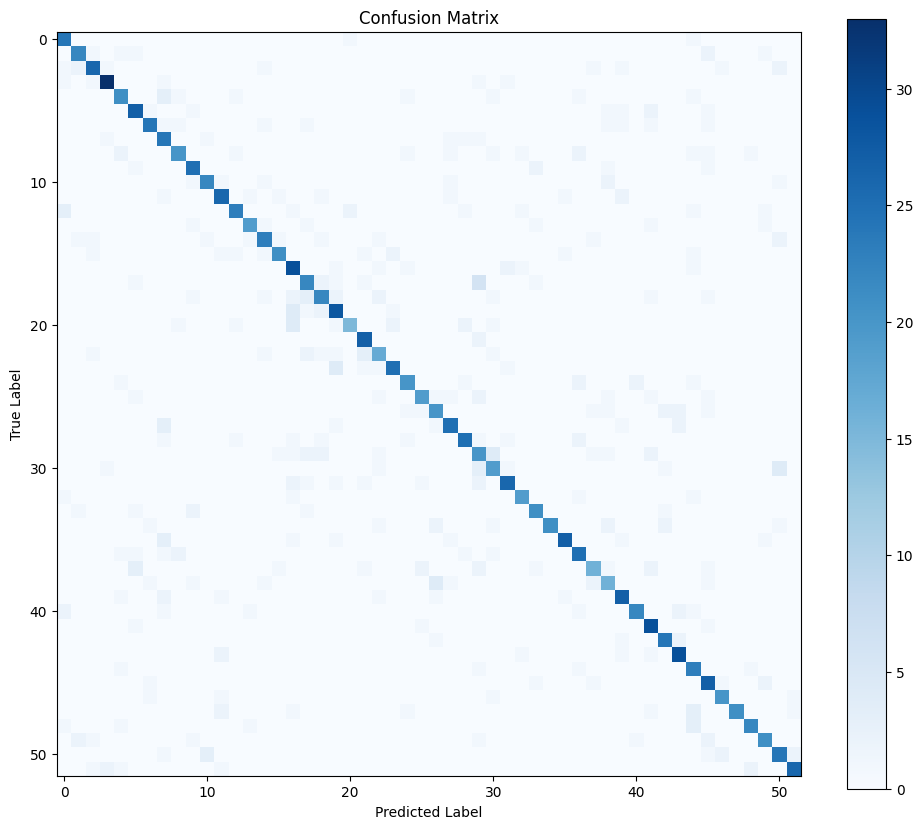

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=range(52), columns=range(52))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()